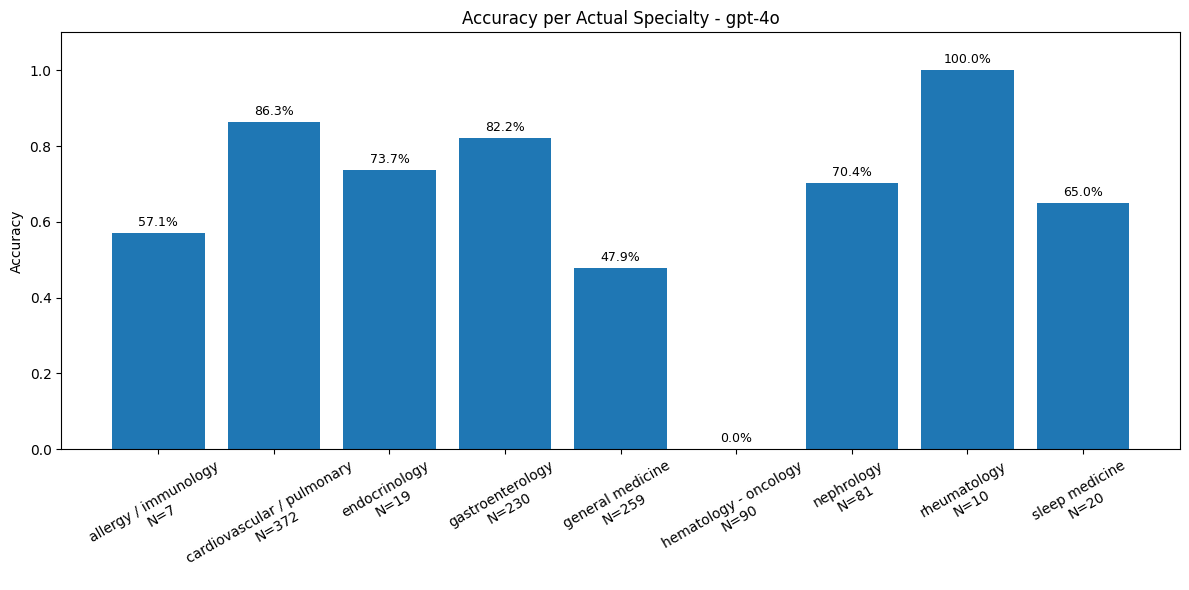

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

# Load CSV
model_name = "gpt-4o"
df = pd.read_csv(f'****{model_name}/triage_pred_{model_name}.csv')

# Group by actual_specialty
grouped = df.groupby('actual_specialty')

# Compute accuracy and count
results = []
for specialty, group in grouped:
    total = len(group)
    correct = (group['actual_specialty'] == group['predicted_specialty']).sum()
    accuracy = correct / total
    results.append({
        'Specialty': f"{specialty}\nN={total}",  # newline for multi-line label
        'Accuracy': round(accuracy, 4),
        'Num_Cases': total
    })

# Create DataFrame
results_df = pd.DataFrame(results)

# Plot
plt.figure(figsize=(12, 6))
bars = plt.bar(results_df['Specialty'], results_df['Accuracy'])

# Add accuracy label on top of bars
for bar, acc in zip(bars, results_df['Accuracy']):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 0.01, f"{acc:.1%}",
             ha='center', va='bottom', fontsize=9)

# Final touches
plt.xticks(rotation=30, ha='center')  # Now centered since labels are multiline
plt.ylabel('Accuracy')
plt.title(f'Accuracy per Actual Specialty - {model_name}')
plt.ylim(0, 1.1)
plt.tight_layout()
plt.show()
